# Feature Analysis - Random Forest

### Import required libraries

In [1]:
import sys, os
import itertools
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.utils import resample

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def progressBar(value, endvalue, bar_length=50):
    percent = float(value) / endvalue
    arrow = '=' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r[{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))

### Import Data

In [3]:
data = pd.read_csv(os.path.join(os.path.abspath(os.pardir), 'src/dataset', 'data_101718.csv'), low_memory=False)

In [4]:
data.head()

,pid,xnorm,ynorm,znorm,cardistnorm,ca,voxelcount0i,graylevels0i,energy0i,entropy0i,...,srlgle15c,srhgle15c,lrlgle15c,lrhgle15c,extrudedsurfacearea15c,extrudedvolume15c,extrudedsurfacevolumeratio15c,boxcountingdimension15c,informationdimension15c,correlationdimension15c
0,129381,-40.78346,-8.199849,29.363550,50.91901,0,10.0,10.0,2221248.0,0.000000,...,0.000351,17872.487,0.000949,42115.337,4760376.9,10073969.0,0.472542,2.091545,2.098287,-74.249922
1,100676,-53.82082,-38.156560,-3.371359,66.06035,0,351.0,260.0,176300000.0,200.078200,...,0.023536,13326.403,0.107683,45091.633,6061283.1,10260464.0,0.590742,2.065475,2.089445,-73.135671
2,132772,49.27720,-35.530340,-1.662529,60.77345,0,18.0,18.0,2805381.0,0.000000,...,0.000159,54901.246,0.000356,174473.340,6801351.9,11157162.0,0.609595,2.189789,2.194593,-78.016611
3,126967,21.59079,15.484310,27.472460,38.21861,1,1374.0,625.0,135400000.0,1900.617600,...,0.005102,37566.835,0.012797,163982.200,6179906.4,9170642.1,0.673879,2.145406,-0.061130,-76.017566
4,102562,80.64488,16.086080,-69.602640,107.73530,0,173.0,159.0,46611581.0,28.754888,...,0.000151,210927.090,0.000230,671420.660,8901488.9,8746977.7,1.017664,2.117663,-0.058523,-74.898571


In [5]:
data.shape

(3701, 274)

### Data Cleaning 

Let's take a look at the missing data, and try to figure our the best way to clean up our data.

Drop out the columns that have over 90% missing data points.

In [6]:
df = data.dropna(thresh=len(data)*.90, axis=1)

Drop out any rows that are missing more than 50% of the required columns

In [7]:
df = df.dropna(thresh=df.shape[1]*.5)

Drop out any rows that are missing the target value 

In [8]:
df = df.dropna(axis=1, subset=df['ca'])

Fill the rest of missing entries with the mean of each col

In [9]:
df = df.apply(lambda col: col.fillna(col.mean()))

In [10]:
df.isnull().sum().any()

False

### Data Exploration 

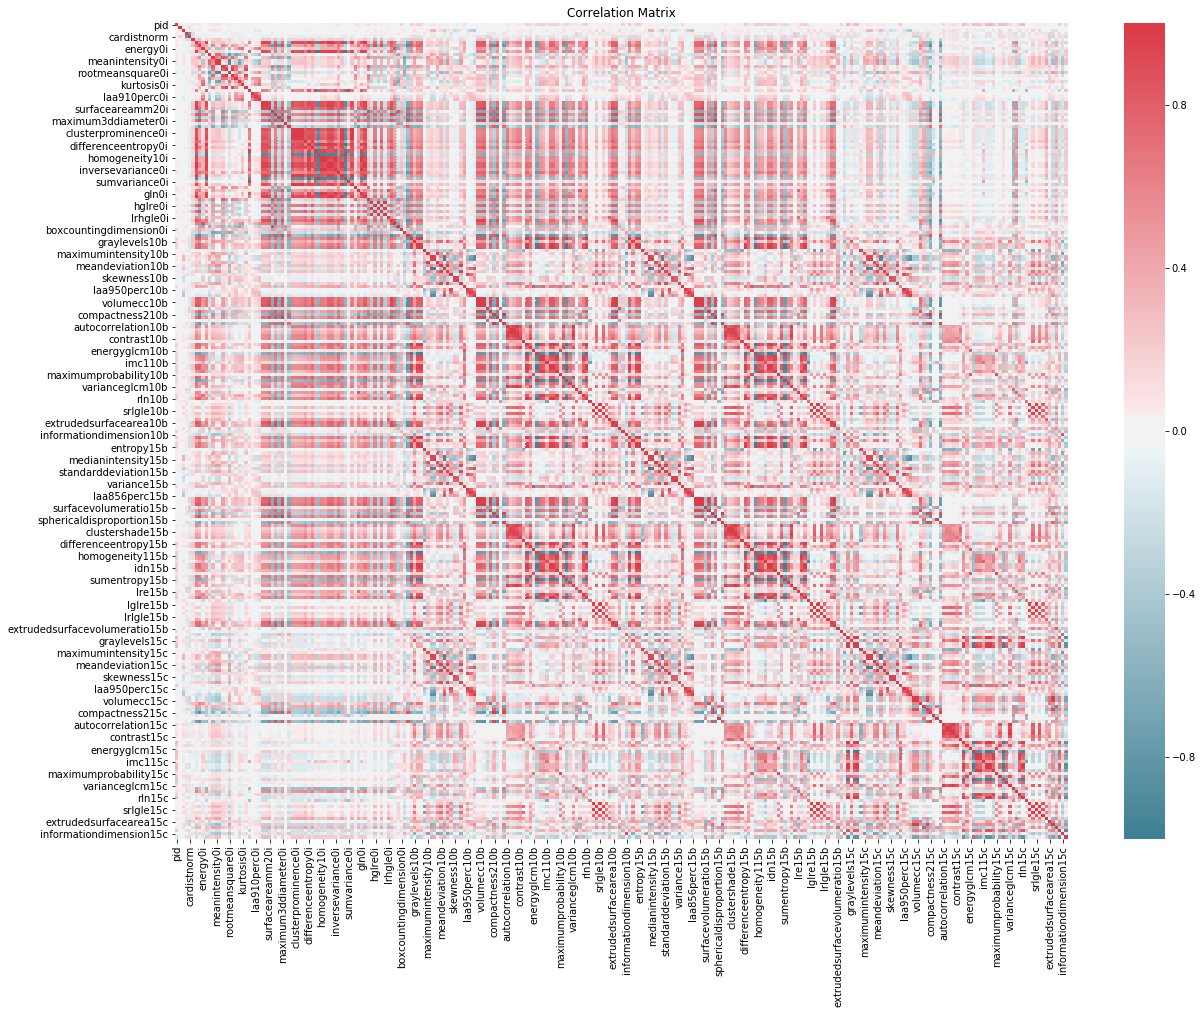

In [11]:
cor_mat = df.corr(method='pearson')
fig, ax =plt.subplots(figsize=(20, 15))
plt.title("Correlation Matrix")
sns.heatmap(
    cor_mat, mask=np.zeros_like(cor_mat, dtype=np.bool), 
    cmap=sns.diverging_palette(220, 10, as_cmap=True)
)

In [12]:
features = list(df.columns.values)
features.remove('pid')
features.remove('ca')

Let's balance out the pos and neg samples in the dataset

In [13]:
df_neg = df[df.ca==0]
df_pos = df[df.ca==1]

Upsample the pos samples

In [14]:
df_pos_upsampled = resample(
    df_pos,
    n_samples=len(df_neg),
    replace=True, 
    random_state=2018
)
df_upsampled = pd.concat([df_pos_upsampled, df_neg])

Downsample the neg samples

In [15]:
df_neg_downsampled = resample(
    df_neg,
    n_samples=len(df_pos),
    replace=True, 
    random_state=2018
)
df_downsampled = pd.concat([df_pos, df_neg_downsampled])

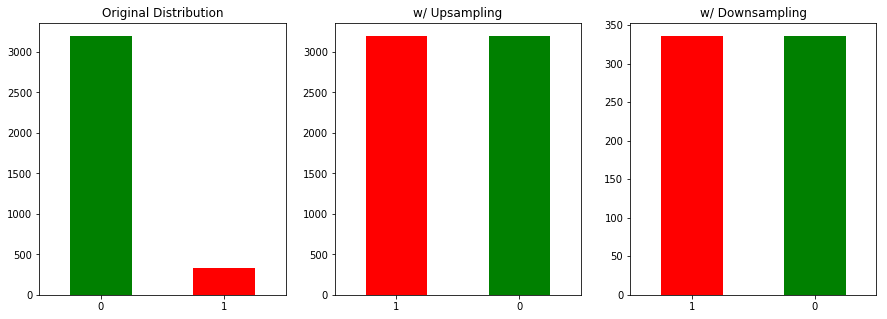

In [16]:
fig, axes = plt.subplots(figsize=(15,5), nrows=1, ncols=3)
df.ca.value_counts().plot.bar(ax=axes[0], rot=False, title='Original Distribution', color=['g','r'])
df_upsampled.ca.value_counts().plot.bar(ax=axes[1], rot=False, title='w/ Upsampling', color=['r','g'])
df_downsampled.ca.value_counts().plot.bar(ax=axes[2], rot=False, title='w/ Downsampling', color=['r','g'])

### Setup Classifier

Normalize Data

In [17]:
# original distribution
#X = StandardScaler().fit_transform(df[features])
#y = df.ca.values

# w/upsampling
#X = StandardScaler().fit_transform(df_upsampled[features])
#y = df_upsampled.ca.values

# w/downsampling
X = StandardScaler().fit_transform(df_downsampled[features])
y = df_downsampled.ca.values

Specify parameters to test

In [18]:
rfc=RandomForestClassifier(random_state=2018)
param_grid = { 
    'n_estimators': [100, 300, 500],
    'max_features': ['auto', 'sqrt'],
    'criterion'   : ['gini', 'entropy'],
    'class_weight': ['balanced', 'balanced_subsample'],
}

Find the best parameters with GridSearchCV for (parallel 5 folds cross-validation)

In [19]:
%%time
optimizer = GridSearchCV(
    rfc, param_grid=param_grid, cv=5, 
    scoring='roc_auc', verbose=10, n_jobs=-1
).fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=100 
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=100 
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=100 
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=100 
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=100 
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=300 
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=300 
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=300 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, n_estimators=100, score=0.9016003460207611, total=   0.7s
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=300 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, n_estimators=100, score

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s


[CV]  class_weight=balanced, criterion=gini, max_features=auto, n_estimators=300, score=0.9075475778546713, total=   2.1s
[CV]  class_weight=balanced, criterion=gini, max_features=auto, n_estimators=300, score=0.8692359100022278, total=   2.1s
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=500 
[CV] class_weight=balanced, criterion=gini, max_features=auto, n_estimators=500 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, n_estimators=300, score=0.8632212073958565, total=   2.1s
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, n_estimators=300, score=0.8204499888616619, total=   2.1s
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, n_estimators=300, score=0.8964134551124971, total=   2.1s
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_e

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s


[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=100, score=0.8609935397638673, total=   0.7s
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=100, score=0.8538650033415016, total=   0.7s
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=300 
[CV]  class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=100, score=0.8095344174649143, total=   0.7s
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=300 
[CV]  class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=100, score=0.8921808866117175, total=   0.7s
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=300 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, n_estimators=500, score=0.8696814435286255,

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.5s


[CV]  class_weight=balanced, criterion=gini, max_features=auto, n_estimators=500, score=0.8249053241256405, total=   3.5s
[CV]  class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=300, score=0.9075475778546713, total=   2.2s
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=500 
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=500 
[CV]  class_weight=balanced, criterion=gini, max_features=auto, n_estimators=500, score=0.8981955892180886, total=   3.6s
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=500 
[CV]  class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=300, score=0.8692359100022278, total=   2.2s
[CV] class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=500 
[CV]  class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=300, score=0.8632212073958565, total=   2.2s
[CV] class_weight=balanced, criterion=entropy, max_features=auto, 

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.7s


[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=100, score=0.9167387543252595, total=   0.9s
[CV] class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=100 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=100, score=0.8671196257518379, total=   1.0s
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=100, score=0.8782579639117843, total=   1.0s
[CV] class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=100 
[CV] class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=300 
[CV]  class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=500, score=0.9096020761245676, total=   3.6s
[CV] class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=300 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=100, score=0.8168857206504789, total=   0.9s
[CV] class_weight=balanced, criterion=entr

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.8s


[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=300, score=0.922037197231834, total=   2.9s
[CV] class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=500 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=300, score=0.8701269770550233, total=   2.9s
[CV] class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=500 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=300, score=0.8770327467141902, total=   2.9s
[CV] class_weight=balanced, criterion=entropy, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=300, score=0.8242370238360436, total=   2.9s
[CV] class_weight=balanced, criterion=entropy, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced, criterion=entropy, max_features=sqrt, n_estimators=100, score=0.9167387543252595, total=   1.0s
[CV] class_weight=balanced, criterion=en

[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   14.0s


[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=500, score=0.8694586767654265, total=   5.3s
[CV] class_weight=balanced, criterion=entropy, max_features=sqrt, n_estimators=300 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=500, score=0.8762530630429939, total=   5.3s
[CV] class_weight=balanced, criterion=entropy, max_features=sqrt, n_estimators=300 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=500, score=0.9209558823529411, total=   5.4s
[CV] class_weight=balanced, criterion=entropy, max_features=sqrt, n_estimators=500 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=500, score=0.8233459567832481, total=   5.5s
[CV] class_weight=balanced, criterion=entropy, max_features=sqrt, n_estimators=500 
[CV]  class_weight=balanced, criterion=entropy, max_features=auto, n_estimators=500, score=0.9073290265092447, total=   5.6s
[CV] class_weight=balanced, criterion=e

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   19.0s


[CV]  class_weight=balanced_subsample, criterion=gini, max_features=auto, n_estimators=100, score=0.8608821563822677, total=   1.0s
[CV] class_weight=balanced_subsample, criterion=gini, max_features=auto, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=gini, max_features=auto, n_estimators=100, score=0.8497438182223213, total=   1.0s
[CV] class_weight=balanced_subsample, criterion=gini, max_features=auto, n_estimators=300 
[CV]  class_weight=balanced_subsample, criterion=gini, max_features=auto, n_estimators=100, score=0.8130986856760972, total=   1.0s
[CV] class_weight=balanced_subsample, criterion=gini, max_features=auto, n_estimators=300 
[CV]  class_weight=balanced_subsample, criterion=gini, max_features=auto, n_estimators=100, score=0.8914012029405213, total=   0.9s
[CV] class_weight=balanced_subsample, criterion=gini, max_features=auto, n_estimators=300 
[CV]  class_weight=balanced, criterion=entropy, max_features=sqrt, n_estimators=500, score=0.920955882352941

[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   24.3s


[CV]  class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=100, score=0.8994377162629759, total=   1.1s
[CV] class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=gini, max_features=auto, n_estimators=300, score=0.8981955892180886, total=   2.8s
[CV] class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=100, score=0.8608821563822677, total=   0.9s
[CV] class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=100, score=0.8497438182223213, total=   0.9s
[CV] class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=300 
[CV]  class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=100, score=0.81309868

[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   28.6s


[CV]  class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=300, score=0.8625529071062596, total=   2.6s
[CV] class_weight=balanced_subsample, criterion=entropy, max_features=auto, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=entropy, max_features=auto, n_estimators=100, score=0.9185769896193772, total=   1.3s
[CV] class_weight=balanced_subsample, criterion=entropy, max_features=auto, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=300, score=0.8981955892180886, total=   2.7s
[CV]  class_weight=balanced_subsample, criterion=gini, max_features=sqrt, n_estimators=300, score=0.8212296725328582, total=   2.8s
[CV] class_weight=balanced_subsample, criterion=entropy, max_features=auto, n_estimators=100 
[CV] class_weight=balanced_subsample, criterion=entropy, max_features=auto, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=entropy, max_features=auto, n_estimators=100

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   35.1s


[CV]  class_weight=balanced_subsample, criterion=entropy, max_features=auto, n_estimators=300, score=0.8756961461349967, total=   3.4s
[CV] class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=entropy, max_features=auto, n_estimators=300, score=0.8267988416128313, total=   3.3s
[CV] class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=entropy, max_features=auto, n_estimators=300, score=0.9025395411004679, total=   3.4s
[CV] class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=100, score=0.9185769896193772, total=   1.2s
[CV] class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=100 
[CV]  class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estim

[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed:   45.2s remaining:    0.8s


[CV]  class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, n_estimators=500, score=0.9012029405212743, total=   4.0s


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   45.6s finished


CPU times: user 2.71 s, sys: 264 ms, total: 2.97 s
Wall time: 47.7 s


In [20]:
optimizer.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_features': 'auto',
 'n_estimators': 300}

### Benchmark

Run classifier with cross-validation and claculate the accuracy of the model based on True-Positive and False-Positive predictions

[=================================================>] 100%

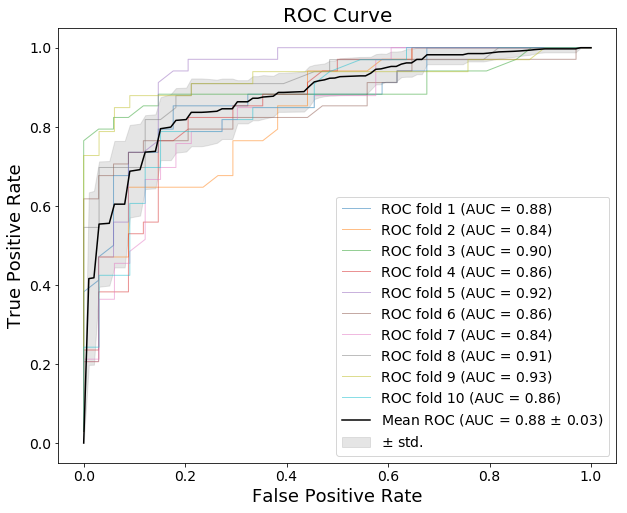

In [21]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2018).split(X, y)
classifier = RandomForestClassifier(**optimizer.best_params_)

tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,8))

for itr, (train, test) in enumerate(cv):
    progressBar(itr+1, n_splits) 
    
    # get predictions
    probs = classifier.fit(X[train], y[train]).predict_proba(X[test])
    
    # compute AUC
    fpr, tpr, thresholds = roc_curve(y[test], probs[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(
        fpr, tpr, lw=1, alpha=0.5,
        label='ROC fold %d (AUC = %0.2f)' % (itr+1, roc_auc)
    )

# plot avg AUC    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(
    mean_fpr, mean_tpr, color='k',
    label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc)
)

# plot std
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(
    mean_fpr, tprs_lower, tprs_upper,
    color='grey', alpha=.2, label=r'$\pm$ std.'
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('ROC Curve', fontsize=20)
plt.legend(loc="lower right", fontsize=14)
plt.show()

[=================================================>] 100%

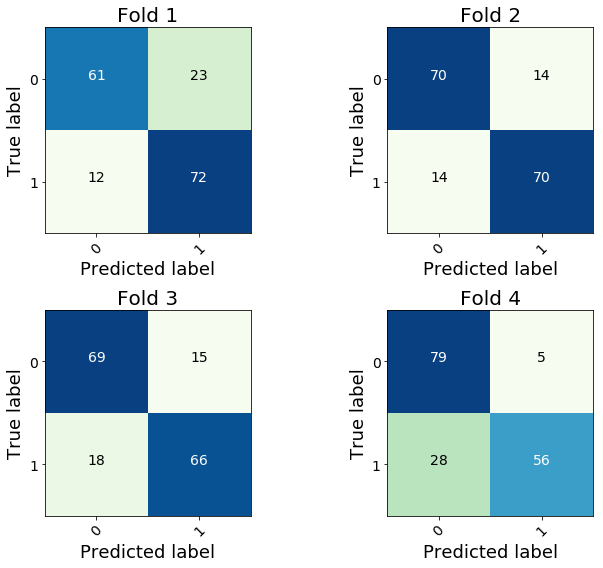

In [22]:
n_splits = 4
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2018).split(X, y)
classifier = RandomForestClassifier(**optimizer.best_params_)
classes = df.ca.unique()

fig = plt.figure(figsize=(10,8))
for itr, (train, test) in enumerate(cv):
    progressBar(itr+1, n_splits) 
        
    # get predictions
    y_pred = classifier.fit(X[train], y[train]).predict(X[test])
    
    # compute confusion matrix
    matrix = confusion_matrix(y[test], y_pred)
    
    # plot confusion matrix
    ax = fig.add_subplot(2,2,itr+1)
    ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.GnBu)
    
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(
            j, i, format(matrix[i, j], 'd'),
            horizontalalignment="center",
            fontsize=14, color="white" if matrix[i, j] > matrix.max()/2 else "black"
        )
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.title('Fold %d' % (itr+1), fontsize=20)

plt.tight_layout()

Plot Importance Score by Feature

In [23]:
importances = zip(features, map(lambda x: round(x, 2), classifier.feature_importances_))
scores = pd.DataFrame([list(score) for score in importances], 
    columns=['Feature', 'Importance Score']).sort_values(by='Importance Score', ascending=False)

In [24]:
scores.head(50)

,Feature,Importance Score
35,clustershade0i,0.02
58,hglre0i,0.02
60,srhgle0i,0.02
51,varianceglcm0i,0.02
36,clustertendency0i,0.02
2,znorm,0.02
37,contrast0i,0.01
39,dissimilarity0i,0.01
48,sumaverage0i,0.01
50,sumvariance0i,0.01


Text(0.5,1.05,'Importance Score per Feature')

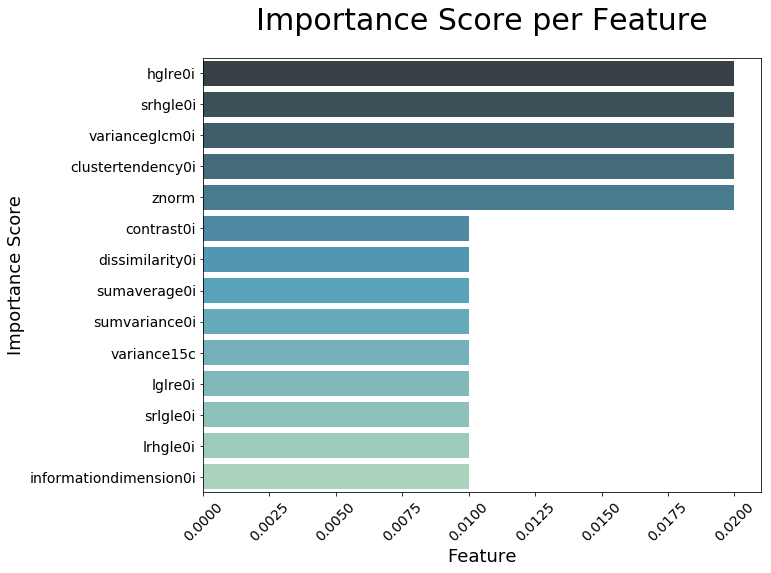

In [25]:
plt.figure(figsize=(10,8))
sns.barplot(data=scores[1:15], x='Importance Score', y='Feature', palette='GnBu_d')
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Feature', fontsize=18)
plt.ylabel('Importance Score', fontsize=18)
plt.title('Importance Score per Feature', fontsize=30, y=1.05)